<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/1_Probabildades_Bayes/1_TAM_ConceptosBasicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicios Capítulo 1 - Teoría de Aprendizaje de Máquina

Elaborado por: Andrés Marino Álvarez Meza, amalvarezme@unal.edu.co

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

Se construyen los datos a partir del modelo:

$t_n = A\sin(2\pi F_o x_n) + \eta_n$

con:

$x_n \in [0,T_o]$

$T_o=1/F_o$

$\eta \sim \mathscr{G}(\eta_n|0,\sigma^2_\eta)$

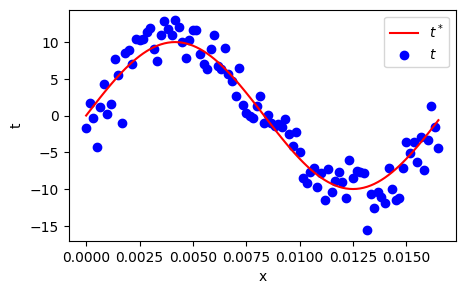

In [2]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$') # rial data 
plt.scatter(X,t,c='b',label='$t$') # datos vistos (samples)  
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


## Solución por mínimos cuadrados:

Se asume mapeo $\phi:\mathbb{R}^P\to\mathbb{R}^Q$, con $Q\geq P.$

Dado el conjunto de datos $\{\phi(\mathbf{x}_n) \in \mathbb{R}^Q, t_n \in \mathbb{R}\}_{n=1}^N,$ podemos definir el modelo lineal:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\mathbf{w}\in\mathbb{R}^Q$

## Estimador por mínimos cuadrados:

El estimador generalizado de mínimos cuadrados con regularización L2 (también conocido como modelo lineal rígido - linear ridge regression), se puede plantear como:

$$\mathbf{w}_{MC2} = \arg\min_{\mathbf{w}} \|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2 + \lambda \|\mathbf{w}\|^2_2$$

con:

$\mathbf{t} = [t_1,t_2,\cdots,t_n]^\top\in\mathbb{R}^N$

$\pmb{\Phi}=[\phi(\mathbf{x}_1),\phi(\mathbf{x}_2),\cdots,\phi(\mathbf{x}_N)]^\top\in\mathbb{R}^{N\times Q}$

$\lambda\in\mathbb{R}^{+}$

Derivando e igualando a cero para encotrar el mínimo de la función de costo, tenemos que:

$$\mathbf{w}_{mc} = \left(\pmb{\Phi}^\top \pmb{\Phi}+\lambda\mathbf{I_Q}\right)^{-1}\pmb{\Phi}^\top \mathbf{t}$$

$\mathbf{I}_Q$: matriz identidad de tamaño $Q$.



0


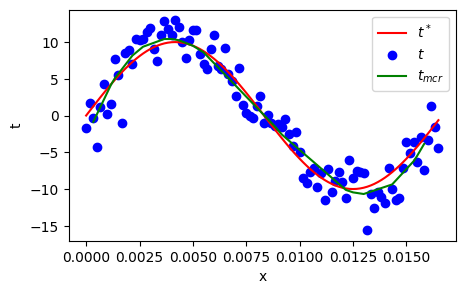

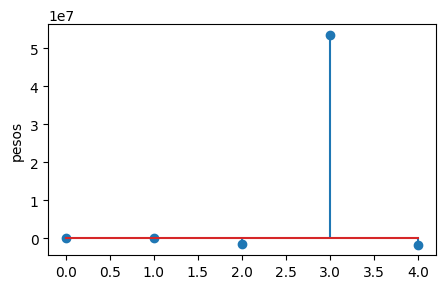

In [3]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import ShuffleSplit


#generación representación polinomial
#desde la libreria sklearn
Q = 4#grado del polinomio # orden to print some functions   
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)#representar datos desde polinomio

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

train_i = np.sort(train_i)
test_i = np.sort(test_i)

reg_mc.fit(Phi[train_i],t[train_i])

t_mc = reg_mc.predict(Phi[test_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(reg_mc.coef_)
plt.ylabel('pesos')
plt.show()

## Implementando solución por svd

In [4]:
def regsvd(Phi,t,lambdaR=0,tol=1e-16):
  S = Phi.T.dot(Phi) + lambdaR*np.eye(Phi.shape[1])
  val,vec = np.linalg.eigh(S)
  print(val.shape,vec.shape)
  ind = val > tol #valores propios mayores a 0
  Sinv = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
  return Sinv.dot(Phi.T.dot(t)),val


(5,) (5, 5)


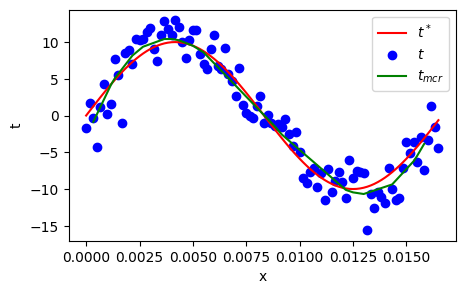

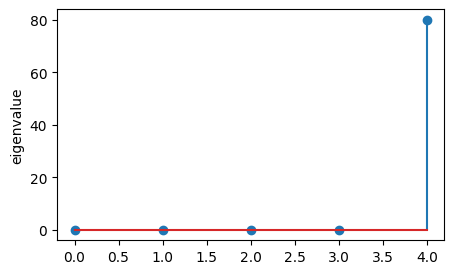

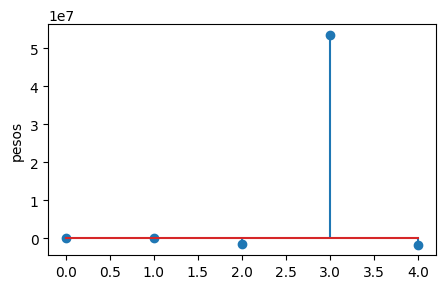

In [5]:
wml,val = regsvd(Phi[train_i],t[train_i],lambdaR=lambdaR)

t_mc = Phi[test_i].dot(wml)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(val)
plt.ylabel('eigenvalue')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(wml)
plt.ylabel('pesos')
plt.show()

# Predictiva desde máxima verosimilitud

Para el caso de ruido blanco Gaussiano, tenemos que:

$\eta_n \sim p(\eta_n) = \mathscr{G}(\eta_n|0,\sigma_\eta^2)$

con:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\eta_n = t_n - \phi(\mathbf{x}_n)\mathbf{w}^\top$

Por lo tanto:

$p(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2)$

Podemos encontrar los pesos y la varianza maximizando el log-verosimilitud:

$$\mathbf{w}_{ML} = \arg\max_{\mathbf{w},\sigma_\eta^2} \log\left(\prod_{n=1}^N\mathscr{G}(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2)\right)$$

Asumiendo datos i.i.d.:

$$\mathbf{w}_{ML},\sigma_{ML}^2 = \arg\max_{\mathbf{w},\sigma_\eta^2} -\frac{N}{2}\log(2\pi)-\frac{N}{2}\log(\sigma_\eta^2)-\frac{1}{2\sigma^2}\|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2$$

Derivando respecto a las variables de interés, e igualando a 0:

$$\sigma^2_{ML} = \frac{1}{N}\sum_\limits{n=1}^N\left(t_n-\phi(\mathbf{x}_n)\mathbf{w}^\top\right)^2$$

$$\mathbf{w}_{ML} = \left(\pmb{\Phi}^\top \pmb{\Phi}\right)^{-1}\pmb{\Phi}^\top \mathbf{t}$$


La fdp predictiva, para un nuevo dato $\mathbf{x}_*$, se puede estimar como:

$$p(t_*|\mathbf{x}_*,\mathbf{t},\pmb{\Phi},\mathbf{w}_{ML},\sigma^2_{ML})=\mathscr{G}(t_*|\phi(\mathbf{x}_*)\mathbf{w}_{ML}^\top,\sigma_{ML}^2)$$

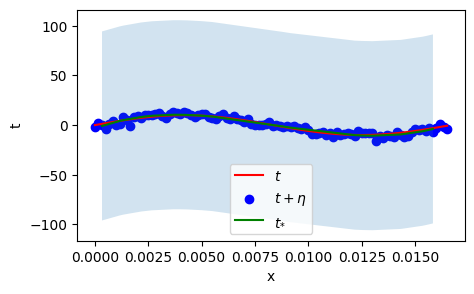

9065.14470154572


In [6]:
#gráfica estimación con predictiva en ML:
var_ml = (np.linalg.norm(t[train_i]-reg_mc.predict(Phi[train_i]))**2)/len(t[train_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t$')
plt.scatter(X,t,c='b',label='$t+\eta$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{*}$')
plt.fill_between(X[test_i].ravel(), t_mc.ravel() - np.sqrt(var_ml)*np.ones(len(t_mc)),
                t_mc.ravel() + np.sqrt(var_ml)*np.ones(len(t_mc)), alpha=0.2)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

print(var_ml)



## Teorema del límite central

Sea $x_n \sim p(x_n)$ una variable aleatoria con fdp $p(x_n)$.

La combinación:

$a_0 x_0+a_1x_1+a_2x_2+ \cdots a_N x_N \sim \mathscr{G}(\sum_n a_n x_n | \mu_,\sigma^2)$

Siendo $
\mathscr{G}$ una fdp Gaussiana.
## Ejemplo

Sea $x\sim \mathscr{U}(x|0,1)$ una variable aleatoria con fdp Uniforme. Mediante una simulación de Monte-Carlo de 1000 repeticiones, encuentre la estimación por histograma de la fdp de la media muestral $x$, con base al muestreo desde la fdp Uniforme con $N\in\{1.2.10\}$ datos.

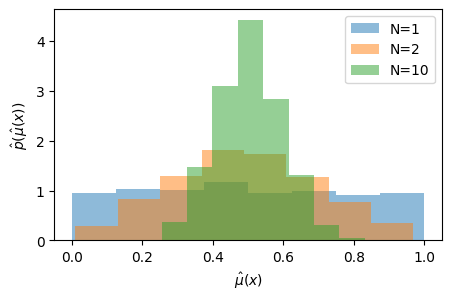

In [7]:
#simulación del teorema del límite central
import numpy as np
import matplotlib.pyplot as plt

#posibles cantidades de datos
N = np.array([1,2,10])
#repeticiones del experimento - simulación de monte carlo
M = 1000
mlc = np.zeros((M,len(N)))

plt.figure(figsize=(5,3))
for i in range(len(N)):#recorrer cantidad de muestras
    for j in range(M): #recorrer iteraciones de monte carlo
        xdata = np.random.rand(N[i])#simulamos datos desde una fdp uniforme
        mlc[j,i] = xdata.mean() #estimación media muestral x
    plt.hist(mlc[:,i],bins=8, label='N='+str(N[i]),density=True, alpha=0.5) #graficar histograma

plt.legend()
plt.xlabel('$\hat{\mu}(x)$')
plt.ylabel('$\hat{p}(\hat{\mu}(x))$')
plt.show()

# Guassianas condicionales y máximo a posteriori

Para resolver el regresor Bayesiano completo, necesitamos encontrar la probabilidad condicional dado una probabilidad conjunta Gaussiana.

Para el caso del máximo a posteriori, desde el teorema de Bayes, tenemos que (se simplifica el modelo en función de la salida y los pesos para facilitar la notación):

$p(\mathbf{t},\mathbf{w})=p(\mathbf{w},\mathbf{t})$

$p(\mathbf{t}|\mathbf{w})p(\mathbf{w})=p(\mathbf{w}|\mathbf{t})p(\mathbf{t})$

El posterior $p(\mathbf{w}|\mathbf{t})$ se puede encontrar como:

$$p(\mathbf{w}|\mathbf{t})=\frac{p(\mathbf{t}|\mathbf{w})p(\mathbf{w})}{p(\mathbf{t})}$$

con evidencia:


$p(\mathbf{t})=\int p(\mathbf{t}|\mathbf{w})p(\mathbf{w}) d\mathbf{w}$

Para el caso de ruido y pesos modelados mediante fdp Gaussinas:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\eta_n \sim p(\eta_n)= \mathscr{G}(\eta_n|0,\sigma_\eta^2)$

$\eta_n = t_n - \phi(\mathbf{x}_n)\mathbf{w}^\top$

Por lo tanto:

$p(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}\left(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2\right)$

Además:

$p(\mathbf{w})= \mathscr{G}(\mathbf{w}|0,\sigma_w^2\mathbf{I}_Q)$

El modelo por máximo a-posteriori, simplifica la relación de Bayes mediante la proporcionalidad:

$p(\mathbf{w}|\mathbf{t}) \propto p(\mathbf{t}|\mathbf{w})p(\mathbf{w})$

Por consiguiente, asumiendo datos i.i.d.:

$$\mathbf{w}_{MAP} = \arg\max_{\mathbf{w}} \log\left(\prod_{n=1}^N\mathscr{G}\left(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2\right)\prod_{q=1}^Q \mathscr{G}({w}_q|0,\sigma_w^2)\right)$$

Asumiendo datos i.i.d.:

$$\mathbf{w}_{MAP} = \arg\max_{\mathbf{w}} -\frac{1}{2\sigma_\eta^2}\|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2 - \frac{1}{2\sigma_w^2}\|\mathbf{w}\|^2_2$$

Teniendo en cuenta que los factores de escala no modifican el punto mínimo/máximo en la optmización, podemos factorizar el problema equivalente MAP como:


$$\mathbf{w}_{MAP} = \arg\min_{\mathbf{w}} \|\mathbf{t}-\pmb{\Phi}\mathbf{w}^\top\|^2_2 + \frac{\sigma^2_\eta}{\sigma_w^2}\|\mathbf{w}\|^2_2$$

Bajo estas suposiciones, el problema de optimización de MAP asumiendo ruido y prior Gaussianos, es equivalente a la optimización de mínimos cuadrados regularizados con $\lambda=\frac{\sigma^2_\eta}{\sigma_w^2}.$

Ahora, analizando un modelo lineal Gaussiano desde la conjunta:


$\mathbf{z} = [\mathbf{x}_a,\mathbf{x}_b] \sim \mathscr{G}(\mathbf{z}|\pmb{\mu},\mathbf{\Sigma})$

tenemos que:

$p(\mathbf{x}_a|\mathbf{x}_b)=\mathscr{G}(\mathbf{x}_a|\pmb{\mu}_{a|b},\mathbf{\Sigma}_{a|b})$


donde:

$\pmb{\mu}_{a|b}=\pmb{\mu}_{a}+\mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1}(\mathbf{x}_b - \pmb{\mu}_b)$

$\mathbf{\Sigma}_{a|b} = \mathbf{\Sigma}_{aa}-\mathbf{\Sigma}_{ab}\mathbf{\Sigma}_{bb}^{-1}\mathbf{\Sigma}_{ba}$

y

$p(\mathbf{x}_a)=\mathscr{G}(\mathbf{x}_a|\pmb{\mu}_{a},\mathbf{\Sigma}_{aa})$




## Ejemplo:

Sea la variable aleatoria $\mathbf{z} = [x_a,x_b]\sim \mathscr{G}(\mathbf{z}|\pmb{\mu},\mathbf{\Sigma})$, con:

$$\pmb{\mu} = [\mu_a,\mu_b] = [0.5,0.2]$$

$$\pmb{\Sigma}= \begin{bmatrix} \sigma_a^2 & \sigma_{ab}\\ \sigma_{ba} & \sigma^2_{b}\end{bmatrix} = \begin{bmatrix} 0.8 & 0.3\\ 0.3 & 0.6\end{bmatrix} $$


Encuentre y grafique $p(\mathbf{x}_a)=\mathscr{G}(\mathbf{x}_a|\pmb{\mu}_{a},\mathbf{\Sigma}_{aa})$ y $p(\mathbf{x}_a|\mathbf{x}_b)=\mathscr{G}(\mathbf{x}_a|\pmb{\mu}_{a|b},\mathbf{\Sigma}_{a|b})$

a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\devContent\tests\P1\docs\ipykernel_20716\1128833617.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


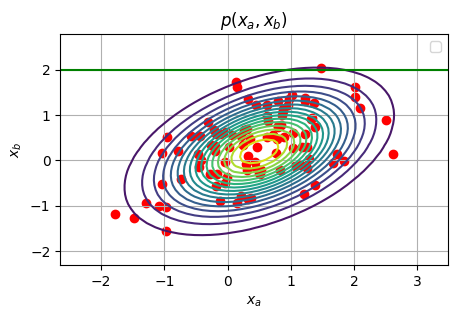

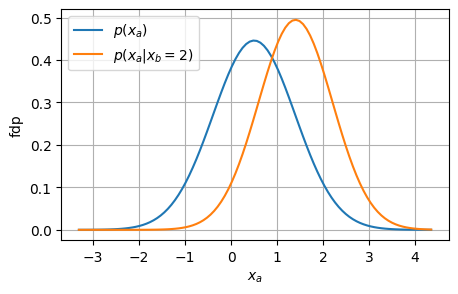

In [8]:
from scipy.stats import multivariate_normal as mn
#simulamos la fdp conjunta
N = 100
muC = np.array([0.5,0.2])
SigmaC = np.array([[0.8,0.3],[0.3,0.6]])
pdfC = mn(muC, SigmaC)
Xd = pdfC.rvs(size=N)
pC = pdfC.pdf(Xd)

#meshgrid contornos
h = 0.02
x_min, x_max = Xd[:, 0].min() - np.std(Xd[:, 0]), Xd[:, 0].max() + np.std(Xd[:, 0])
y_min, y_max = Xd[:, 1].min() - np.std(Xd[:, 1]), Xd[:, 1].max() + np.std(Xd[:, 1])
xx, yy = np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)

X = np.linspace(x_min, x_max, round(0.5*N))
Y = np.linspace(y_min, y_max, round(0.5*N))
X, Y = np.meshgrid(X, Y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# evaluar pdf conjunta
Z = pdfC.pdf(pos)

#x_b = 2
xb = 2
#contornos
plt.figure(figsize=(5,3))
plt.contour(X, Y, Z,levels=20)
#scatter
plt.scatter(Xd[:,0],Xd[:,1],c='r')
plt.plot(np.linspace(x_min,x_max,50),xb*np.ones((50,1)),c='g')
plt.grid()
plt.xlabel('$x_a$')
plt.ylabel('$x_b$')
plt.title('$p(x_a,x_b)$')
plt.legend()
plt.show()


#probabilidad marginal de x_a
mu_a = 0.5
Sigma_a = 0.8
pdf_a = mn(mu_a, Sigma_a)
X_a = np.linspace(1.25*x_min,1.25*x_max,N)
p_a = pdf_a.pdf(X_a)

#probabilidad condicional x_a | x_b = 2
mu_b = 0.2
Sigma_ab = 0.3
Sigma_ba = Sigma_ab
Sigma_b = 0.6

mu_alb = mu_a+Sigma_ab*Sigma_b**(-1)*(xb - mu_b)
Sigma_alb = Sigma_a-Sigma_ab*Sigma_b**(-1)*Sigma_ba
pdf_alb = mn(mu_alb, Sigma_alb)
p_alb = pdf_alb.pdf(X_a)


plt.figure(figsize=(5,3))
plt.plot(X_a,p_a,label='$p(x_a)$')
plt.plot(X_a,p_alb,label='$p(x_a|x_b=2)$')
plt.xlabel('$x_a$')
plt.ylabel('fdp')
plt.grid()
plt.legend()
plt.show()

## Modelo lineal Gaussiano

Sea el prior:

$p(\mathbf{x})=\mathscr{G}(\mathbf{x}|\pmb{\mu},\pmb{\Lambda}^{-1})$

Además, sea la verosimilitud desde un modelo lineal $\mathbf{y} = \mathbf{A}\mathbf{x}+\mathbf{b}$:

$p(\mathbf{y}|\mathbf{x})=\mathscr{G}(\mathbf{y}|\mathbf{A}\mathbf{x}+\mathbf{b},\mathbf{L}^{-1})$

Completando cuadrados sobre la Gaussiana conjunta, tenemos que:

$p(\mathbf{y})=\mathscr{G}(\mathbf{y}|\mathbf{A}\pmb{\mu}+\mathbf{b},\mathbf{L}^{-1}+\mathbf{A}\pmb{\Lambda}^{-1}\mathbf{A}^\top)$

$p(\mathbf{x}|\mathbf{y})=\mathscr{G}(\mathbf{y}|\pmb{\mu}_{x|y},\mathbf{\Sigma}_{x|y})$

con:

$\pmb{\mu}_{x|y} = \mathbf{\Sigma}_{x|y}\left(\mathbf{A}^\top\mathbf{L}(\mathbf{y}-\mathbf{b})+\pmb{\Lambda}\pmb{\mu}\right)$

$\mathbf{\Sigma}_{x|y} = \left(\pmb{\Lambda}+\mathbf{A}^\top\mathbf{L}\mathbf{A}\right)^{-1}$

Para el caso del modelo de regresión:

$t_n = \phi(\mathbf{x}_n)\mathbf{w}^\top + \eta_n$

$\eta_n \sim p(\eta_n)= \mathscr{G}(\eta_n|0,\sigma_\eta^2)$

$\eta_n = t_n - \phi(\mathbf{x}_n)\mathbf{w}^\top$

Por lo tanto, la verosimilitud se puede escribir como:

$p(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}\left(t_n|\phi(\mathbf{x}_n)\mathbf{w}^\top,\sigma_\eta^2\right)$

En forma vectorial:

$p(\mathbf{t}|\pmb{\Phi}\mathbf{w}^\top,\sigma_\eta^2) = \mathscr{G}\left(\mathbf{t}|\pmb{\Phi}\mathbf{w}^\top,\sigma_\eta^2\right)$

Asumiendo el prior:

$p(\mathbf{w}) = \mathscr{G}(\mathbf{w}|\mathbf{m}_o,\mathbf{S}_o)$

El posterior se puede estimar como:

$p(\mathbf{w}|\mathbf{t}) = \mathscr{G}(\mathbf{w}|\mathbf{m}_N,\mathbf{S}_N)$

donde:

$\mathbf{m}_N = \mathbf{S}_N\left(\mathbf{S}_o^{-1}\mathbf{m}_o + \frac{1}{\sigma_\eta^2}\pmb{\Phi}^\top\mathbf{t}\right)$

$\mathbf{S}_N = \left(\mathbf{S}_o^{-1} + \frac{1}{\sigma_\eta^2}\pmb{\Phi}^\top\pmb{\Phi}\right)^{-1}$

Si se impone un prior de la forma:

$p(\mathbf{w}) = \mathscr{G}(\mathbf{w}|0,\sigma_w^2)$

Entonces:

$p(\mathbf{w}|\mathbf{t}) = \mathscr{G}(\mathbf{w}|\tilde{\mathbf{m}}_N,\tilde{\mathbf{S}}_N)$


$\tilde{\mathbf{m}}_N = \frac{1}{\sigma_\eta^2} \tilde{\mathbf{S}}_N\pmb{\Phi}^\top\mathbf{t}$

$\tilde{\mathbf{S}}_N = \left(\frac{1}{\sigma_w^2}\mathbf{I}_Q + \frac{1}{\sigma_\eta^2}\pmb{\Phi}^\top\pmb{\Phi}\right)^{-1} = \left(\frac{1}{\sigma_\eta^2}\right)^{-1}\left(\frac{\sigma_\eta^2}{\sigma_w^2}\mathbf{I}_Q + \pmb{\Phi}^\top\pmb{\Phi}\right)^{-1}$

Reemplazando en la media condicional:

$\tilde{\mathbf{m}}_N = \frac{1}{\sigma_\eta^2} \left(\frac{1}{\sigma_\eta^2}\right)^{-1}\left(\frac{\sigma_\eta^2}{\sigma_w^2}\mathbf{I}_Q + \pmb{\Phi}^\top\pmb{\Phi}\right)^{-1}\pmb{\Phi}^\top\mathbf{t}$


$\tilde{\mathbf{m}}_N = \left(\frac{\sigma_\eta^2}{\sigma_w^2}\mathbf{I}_Q + \pmb{\Phi}^\top\pmb{\Phi}\right)^{-1}\pmb{\Phi}^\top\mathbf{t}$

**Nota:** la solución del modelo lineal Gaussiano para el prior $p(\mathbf{w}) = \mathscr{G}(\mathbf{w}|0,\sigma_w^2)$ y ante ruido blanco Gaussiano $\eta_n \sim p(\eta_n)= \mathscr{G}(\eta_n|0,\sigma_\eta^2)$, es equivalente en la media $\tilde{\mathbf{m}}_N$ a la solución de mínimos cuadrados regularizados.


## Predictiva

Para un nuevo dato $\mathbf{x}_*$, la distribución predictiva referente a la salida $t_*$ se puede calcular como:

$p(t_*|\mathbf{x}_*,\mathbf{t},\mathbf{w}) = \int p(t_*|\mathbf{x}_*,\mathbf{w})p(\mathbf{w}|\mathbf{t})d\mathbf{w}$

$p(t_*|\mathbf{t}) = \int \mathscr{G}\left(t_*|\phi(\mathbf{x}_*)\mathbf{w}^\top,\sigma_\eta^2\right)\mathscr{G}(\mathbf{w}|\tilde{\mathbf{m}}_N,\tilde{\mathbf{S}}_N)d\mathbf{w}$

$p(t_*|\mathbf{x}_*,\mathbf{t},\mathbf{w}) = \mathscr{G}\left(t_*|\phi(\mathbf{x}_*)\tilde{\mathbf{m}}_N^\top,\sigma_\eta^2 + \phi(\mathbf{x}_*)\tilde{\mathbf{S}}_N \phi(\mathbf{x}_*)^\top\right)$



## Ejercicio:

Implementar simulación para el regresor lineal Gaussiano (Bayesiano), para la señal:

Se construyen los datos a partir del modelo:

$t_n = A\sin(2\pi F_o x_n) + \eta_n$

con:

$x_n \in [0,T_o]$

$T_o=1/F_o$

$\eta \sim \mathscr{G}(\eta_n|0,\sigma^2_\eta)$

Imponga prior Gaussiano isotrópico con media cero.





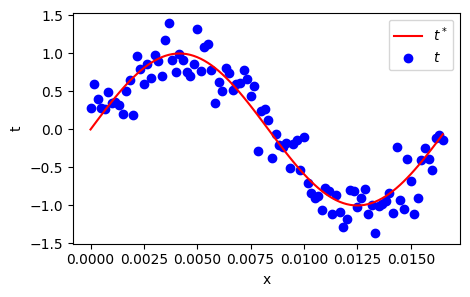

In [9]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 1 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [10]:
#Entrenamiento función regresor lineal Gaussiano: posterior
def my_linGuassiano(X,t,phiQ,sig_eta,sig_w,tol=1e-16):
  Phi = phiQ.fit_transform(X)
  lambdaR = sig_eta/sig_w
  SNinv = Phi.T.dot(Phi) + lambdaR*np.eye(Phi.shape[1])#covarianza
  val,vec = np.linalg.eigh(SNinv)
  ind = val > tol #valores propios mayores a 0
  SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
  mN = SN.dot(Phi.T.dot(t)) #estimación media lineal Gaussiano
  return mN,SN,val

#estimación predictiva modelo lineal Gaussiano
def my_predictivaLG(xnew,phiQ,mN,SN,sig_eta):
  Phinew = phiQ.fit_transform(xnew) #mapeo polinomio Nnew x Q
  mnew = Phinew.dot(mN)
  signew = np.diag(sig_eta*np.eye(Phinew.shape[0]) + Phinew.dot(SN).dot(Phinew.T))
  return mnew, signew

In [11]:
#generación representación polinomial
#desde la libreria sklearn
Q = 9#grado del polinomio
phiQ = PolynomialFeatures(degree=Q)

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

#regresor lineal Gaussiano
sig_eta = 1
sig_w = 1e13
mN,SN,val = my_linGuassiano(X[train_i],t[train_i],phiQ,sig_eta,sig_w)
mnew, signew = my_predictivaLG(X[test_i],phiQ,mN,SN,sig_eta)

print(mnew.shape, signew.shape)

0
(20, 1) (20,)


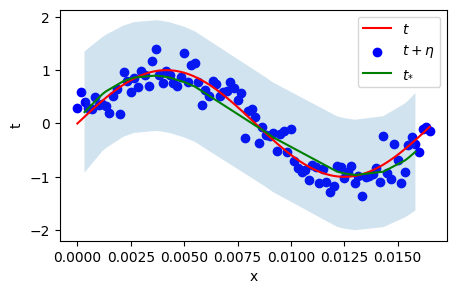

In [12]:
plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t$')
plt.scatter(X,t,c='b',label='$t+\eta$')
plt.plot(X[test_i],mnew,c='g',label='$t_{*}$')
plt.fill_between(X[test_i].ravel(), mnew.ravel() - signew,
                        mnew.ravel() + signew, alpha=0.2)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# Visualización Regresor Bayesiano en Función de los Datos de Entrenamiento

Se plantea un modelo de regresión lineal con ruido y prior Gaussianos isotrópicos.

In [13]:
#graficar pdf 2D
def my_2Dpdf(mu,Sigma,axes,N=100,h=0.02,xlabel_='$w_0$',ylabel_='$w_1$',
             cmap = 'Reds',xlim=None,ylim=None):
  pdfx = mn(mu, Sigma)
  Xx = pdfx.rvs(size=N)
  pp = pdfx.pdf(Xx)
  #meshgrid contornos
  if xlim == None:
    x_min, x_max = pdfx.mean[0] - 4*pdfx.cov[0,0], pdfx.mean[0] + 4*pdfx.cov[0,0]
  else:
    x_min, x_max = xlim[0], xlim[1]
  if ylim == None:
    y_min, y_max = pdfx.mean[1] - 4*pdfx.cov[1,1], pdfx.mean[1] + 4*pdfx.cov[1,1]
  else:
    y_min, y_max = ylim[0], ylim[1]
  xx, yy = np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)

  X = np.linspace(x_min, x_max, round(0.5*N))
  Y = np.linspace(y_min, y_max, round(0.5*N))
  X, Y = np.meshgrid(X, Y)
  # Pack X and Y into a single 3-dimensional array
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X
  pos[:, :, 1] = Y

  # evaluar pdf conjunta
  Z = pdfx.pdf(pos)
  #contornos
  axes.contourf(X, Y, Z,levels=20,cmap = cmap)
  #axes.grid()
  axes.set_xlabel(xlabel_)
  axes.set_ylabel(ylabel_)
  axes.set_xlim(xlim)
  axes.set_xlim(ylim)

  #plt.title('$p(x_a,x_b)$')
  return

def my_linregsyn(mu,Sigma,axes,xmin=-1,xmax=1,Nmod = 10,xlim=[-1.2,1.2],ylim=[-1.2,1.2]):
  pdfw = mn(mu, Sigma)
  wmod = pdfw.rvs(size=Nmod)
  X = np.random.uniform(low=xmin, high=xmax, size=100)
  t = wmod.dot(np.r_[X.reshape(1,-1),np.ones((1,X.shape[0]))])
  axes.plot(X,t.T,c='b')
  axes.set_xlabel('$x$')
  axes.set_ylabel('$f(x|w)$')
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  return

def my_posterior_update(X,t,sig_eta,sig_w,tol=1e-10):
  # X in Real N x P
  # sig_eta varianza ruido Guassiano
  # sig_w varizan prior Gaussiano isotrópico pesos

  lambdaR = sig_eta/sig_w
  SNinv = X.T.dot(X) + lambdaR*np.eye(X.shape[1])#covarianza
  val,vec = np.linalg.eigh(SNinv)
  ind = val > tol #valores propios mayores a 0
  SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
  mN = np.squeeze(SN.dot(X.T.dot(t))) #estimación media lineal Gaussiano
  return mN,SN #mN SN mean y cov Gaussiana del posterior


#estimación predictiva modelo lineal Gaussiano
def my_predictiva_update(xnew,mN,SN,sig_eta):
  #Phinew = phiQ.fit_transform(xnew) #mapeo polinomio Nnew x Q
  mnew = xnew.dot(mN)
  signew = np.diag(sig_eta*np.eye(xnew.shape[0]) + xnew.dot(SN).dot(xnew.T))
  return mnew, signew

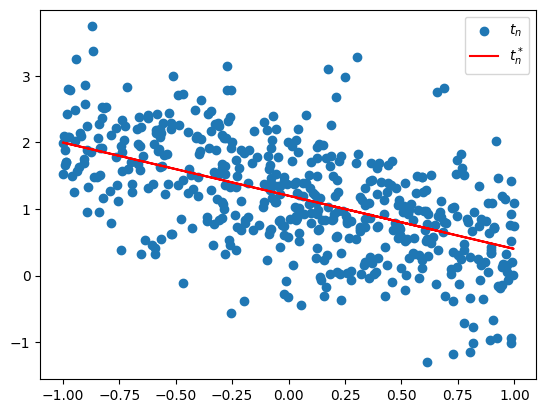

In [14]:
#simular datos regresor lineal + ruido Gaussiano
snrdB = 5 #ruido según SNR dB
#señal limpia - objetivo
N = 500
w_ = np.array([-0.8,1.2]) #pesos modelo original
X = np.c_[np.random.uniform(low=-1, high=1, size=N).reshape(N,1),np.ones((N,1))]
#salida limpia
tt = X.dot(w_.T)
#modelo con función sinoidal contaminada con ruido Gaussiano
sig_eta = var_snr(tt,snrdB)
t = tt + np.sqrt(sig_eta)*np.random.randn(X.shape[0])
plt.scatter(X[:,0],t,label='$t_n$')
plt.plot(X[:,0],tt,'r',label='$t_n^*$')
plt.legend()
plt.show()

0


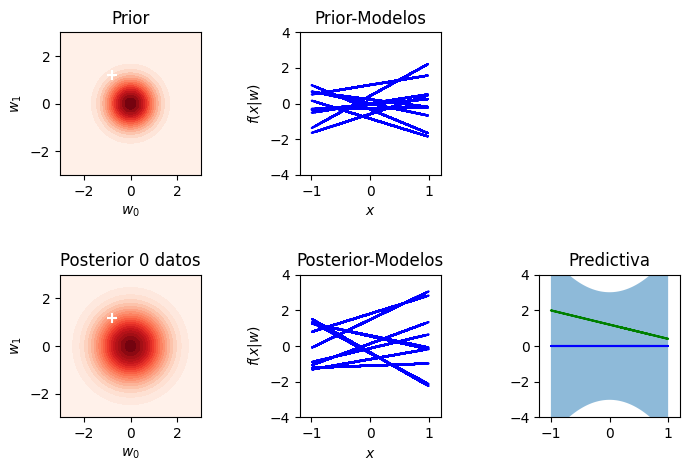

In [15]:
from matplotlib import animation, rc
from IPython.display import HTML

#vector muestreo aleatorio datos en X
ind = np.random.randint(0,X.shape[0],size=X.shape[0])
#definir prior pesos
mu_w = np.array([0,0])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

#limites gráficos
wxlim = [-3,3]
wylim = [-3,3]
xlim = [-1.2,1.2]
ylim = [-4,4]



#figura y axes animación
fig, ax = plt.subplots(2, 3,figsize=(8,5))
ax[0,2].axis('off')
#función para gráfico interactivo
def update(i):
    #actualización regresor Bayesiano
    #Graficar prior
    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()
    ax[1,2].clear()

    my_2Dpdf(mu_w,S_w,axes=ax[0,0],cmap='Reds',xlim=wxlim,ylim=wylim)
    #muestreo regresores desde prior
    my_linregsyn(mu_w,S_w,axes=ax[0,1],xlim=xlim,ylim=ylim)
    #actualizar prior a posterior con 1 dato
    mN,SN = my_posterior_update(X[ind[:i]],t[ind[:i]],sig_eta,sig_w,tol=1e-10)
    my_2Dpdf(mN,SN,axes=ax[1,0],cmap='Reds',xlim=wxlim,ylim=wylim)
    my_linregsyn(mN,SN,axes=ax[1,1],xlim=xlim,ylim=ylim)
    ax[1,1].scatter(X[ind[:i],0],t[ind[:i]],c='r',marker='.')
    #pesos originales
    ax[1,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')
    ax[0,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')

    #graficar predictiva
    mnew,snew = my_predictiva_update(X,mN,SN,sig_eta)
    ax[1,2].plot(X[:,0],tt,c='g')
    ax[1,2].scatter(X[ind[:i],0],t[ind[:i]],c='r',marker='.')
    ax[1,2].plot(X[:,0],mnew,c='b')
    ii = np.argsort(X[:,0]) #organizar eje x para visualizar incertidumbre
    ax[1,2].fill_between(X[ii,0].ravel(), mnew[ii].ravel() - 2*snew[ii],
                        mnew[ii].ravel() + 2*snew[ii], alpha=0.5)
    #Limites para visualizar predictiva
    ax[1,2].set_xlim(xlim)
    ax[1,2].set_ylim(ylim)

    #titulos
    ax[0,0].set_title('Prior')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title('Posterior ' + str(i) + ' datos' )
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7,hspace=0.7)
    print(i)



#desplegar animación
anim = animation.FuncAnimation(fig, update, frames=np.array([0,1,2,3,5,7,9,10,15,20,25,50,100,250,500]), blit=False)
rc('animation', html='jshtml')


In [16]:
anim

0
0
1
2
3
5
7
9
10
15
20
25
50
100
250
500


<Figure size 640x480 with 0 Axes>

# Ejercicio Bonificación Parcial 1 (Hasta 1 unidad)

- Presente la animación de actualización del modelo ilustrado en el ejemplo anterior para el estimador de máxima verosimilitud (graficar estimación con incertidumbre).

- Repetir el ejemplo de la animación para el estimador Bayesiano para la función senoidal contaminada con ruido Gaussiano utilizando mapeo Polinomial de grado 9.

- Incluya la gráfica de la magnitud de los pesos y la matriz covarianza como una imagen.

- Para las dos componentes más importentes, repita la animación del ejemplo.

- Repita para un mapeo por Gaussianas (RBF) de orden 30.



a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.20649e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR

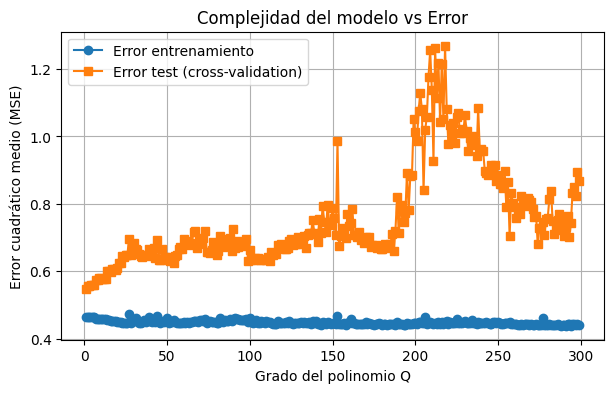

In [17]:
# --- Evaluación de complejidad del modelo polinomial con validación cruzada ---
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Q_range = range(1, 300)  # grados de polinomio a evaluar
train_errors = []
test_errors = []

rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)
    for Q in Q_range:
        phiQ = PolynomialFeatures(degree=Q)
        Phi = phiQ.fit_transform(X)
        Phi_train = Phi[train_i]
        Phi_test = Phi[test_i]
        t_train = t[train_i]
        t_test = t[test_i]
        reg_mc = Ridge(alpha=1e-15)
        reg_mc.fit(Phi_train, t_train)
        t_train_pred = reg_mc.predict(Phi_train)
        t_test_pred = reg_mc.predict(Phi_test)
        train_errors.append(mean_squared_error(t_train, t_train_pred))
        test_errors.append(mean_squared_error(t_test, t_test_pred))

train_errors = np.array(train_errors).reshape(len(Q_range), -1).mean(axis=1)
test_errors = np.array(test_errors).reshape(len(Q_range), -1).mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(Q_range, train_errors, marker='o', label='Error entrenamiento')
plt.plot(Q_range, test_errors, marker='s', label='Error test (cross-validation)')
plt.xlabel('Grado del polinomio Q')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Complejidad del modelo vs Error')
plt.legend()
plt.grid(True)
plt.show()


a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.20649e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
a:\wnOs\LR\machineLearningTheoryEnv\TAM\devEnv\MLT_LR\PYDevEnv\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


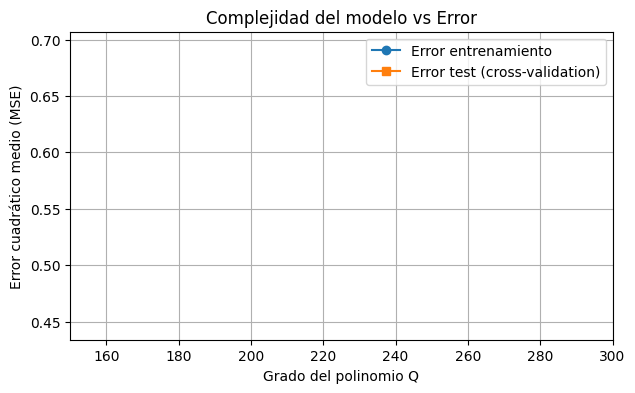

In [18]:
# --- Evaluación de complejidad del modelo polinomial con validación cruzada ---
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Q_range = range(1, 30)  # grados de polinomio a evaluar
train_errors = []
test_errors = []

rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)
    for Q in Q_range:
        phiQ = PolynomialFeatures(degree=Q)
        Phi = phiQ.fit_transform(X)
        Phi_train = Phi[train_i]
        Phi_test = Phi[test_i]
        t_train = t[train_i]
        t_test = t[test_i]
        reg_mc = Ridge(alpha=1e-15)
        reg_mc.fit(Phi_train, t_train)
        t_train_pred = reg_mc.predict(Phi_train)
        t_test_pred = reg_mc.predict(Phi_test)
        train_errors.append(mean_squared_error(t_train, t_train_pred))
        test_errors.append(mean_squared_error(t_test, t_test_pred))

train_errors = np.array(train_errors).reshape(len(Q_range), -1).mean(axis=1)
test_errors = np.array(test_errors).reshape(len(Q_range), -1).mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(Q_range, train_errors, marker='o', label='Error entrenamiento')
plt.plot(Q_range, test_errors, marker='s', label='Error test (cross-validation)')
plt.xlabel('Grado del polinomio Q')
plt.ylabel('Error cuadrático medio (MSE)')
plt.title('Complejidad del modelo vs Error')
plt.legend()
plt.xlim(150,300)
plt.grid(True)
plt.show()    
